# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('The shape of the azdias dataset:', azdias.shape)
print('The shape of the feat_info dataset:', feat_info.shape)

The shape of the azdias dataset: (891221, 85)
The shape of the feat_info dataset: (85, 4)


In [4]:
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [5]:
feat_info.head(3)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# I need to figure out what kind of data that missing_or_unknown holding
print('Total number of elemnts in missing_or_unknown is : ',feat_info['missing_or_unknown'].count())
feat_info['missing_or_unknown'].value_counts()

Total number of elemnts in missing_or_unknown is :  85


[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,XX]      1
[XX]         1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [7]:
mis_=azdias.isnull().sum()
print('Total missing values is : {:,} elements '.format(azdias.isnull().sum().sum()))

Total missing values is : 4,896,838 elements 


In [8]:
#looping for each column in azdias
for column in range(azdias.shape[1]):
    # pick one column of azdias
    col_featue=azdias.columns[column]
    #clean missing_or_unknown 
    missing_list=feat_info.iloc[column,3]
    missing_list=missing_list.replace('[', '').replace(']', '').split(',')
    if missing_list == ['']:
        continue
    else:
        for unknown_code in missing_list:
            if azdias[col_featue].dtype =='object':
                azdias.loc[azdias[col_featue]==unknown_code,col_featue]=np.nan 
            else:   
                unknown_code=int(unknown_code)
                azdias.loc[azdias[col_featue]==unknown_code,col_featue]=np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
after_miss_update = azdias.isnull().sum () 
s1 = pd.Series(mis_, name='Old missing')
s2 = pd.Series(after_miss_update, name='Missing after update')
print('Total missing values after update is : {:,} elements '.format(after_miss_update.sum()))


Total missing values after update is : 8,373,929 elements 


In [10]:
after_miss_update.sum()

8373929

In [11]:
display (pd.concat([s1, s2], axis=1))

,Old missing,Missing after update
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


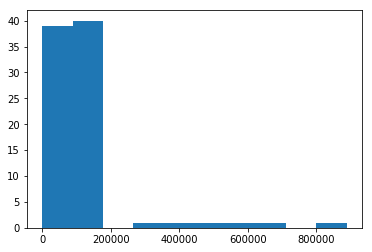

In [12]:
# Investigate patterns in the amount of missing data in each column.
countcol=pd.DataFrame(azdias.shape[0] - azdias.count())
countcol.columns=['count']
plt.hist(countcol['count']);


In [13]:
old=azdias.shape
print('original azdias:',old)

original azdias: (891221, 85)


In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
countcol=countcol[countcol['count']>200000]
azdias=azdias.drop(countcol.index, axis=1)


In [15]:
countcol

,count
AGER_TYP,685843
GEBURTSJAHR,392318
TITEL_KZ,889061
ALTER_HH,310267
KK_KUNDENTYP,584612
KBA05_BAUMAX,476524


In [16]:
print('azdias',azdias.shape)


azdias (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

### Answer: 
As above histogram show the 8 column of outliers with large amount of missing data (>200,000 missing data) so I will remove it.
- TITEL_KZ                 __889061__
- AGER_TYP                 __685843__
- KK_KUNDENTYP             __584612__
- KBA05_BAUMAX             __476524__
- GEBURTSJAHR              __392318__
- ALTER_HH	               __310267__



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

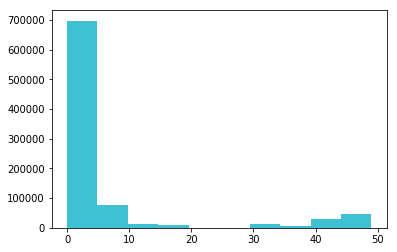

In [17]:
# How much data is missing in each row of the dataset?
countrow=pd.DataFrame(azdias.shape[1] - azdias.count(axis=1))
countrow.columns=['count']
plt.hist(countrow['count'],color='#3ec1d3')

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
count1=countrow[countrow['count']<25]
count2=countrow[countrow['count']>=25]

azdias1=azdias.iloc[count1.index,:]
azdias2=azdias.iloc[count2.index,:]

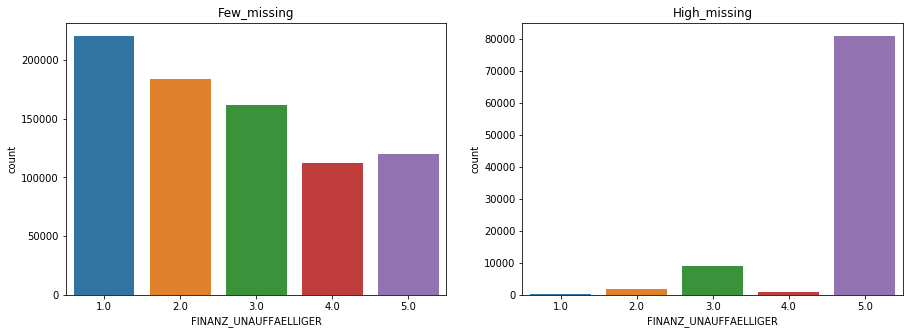

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plotx(column):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title('Few_missing')
    sns.countplot(azdias1[column])
    plt.subplot(1,2,2)
    plt.title('High_missing')
    sns.countplot(azdias2[column])
    plt.show()

plotx('FINANZ_UNAUFFAELLIGER')

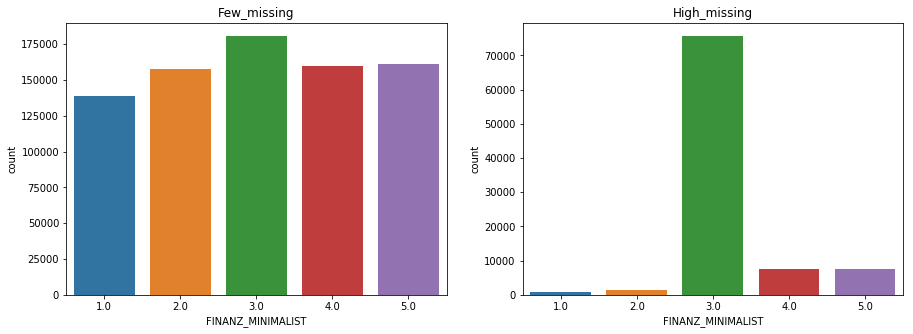

In [20]:
plotx('FINANZ_MINIMALIST')

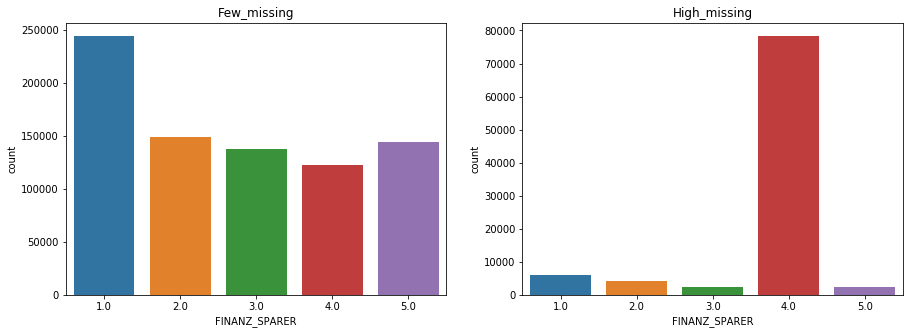

In [21]:
plotx('FINANZ_SPARER')

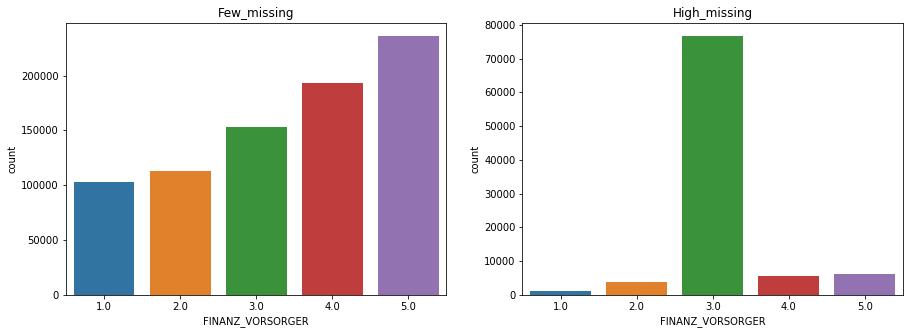

In [22]:
plotx('FINANZ_VORSORGER')

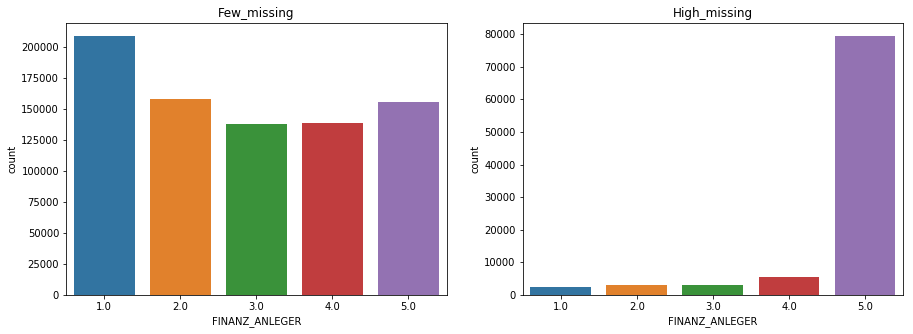

In [23]:
plotx('FINANZ_ANLEGER')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Answer:
Most column in our dataset looks not unevenly distributed. The columns has big  difference in distribution.I will not delete the data since column has NAN that might effect the quality of original data.



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [25]:
#count of each type then create dict
count_type=feat_info.groupby('type').count()
count_type

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


In [26]:
# from count_type dataframe to dict
x=count_type['attribute'].index
y=count_type['attribute']
z=zip(x,list(y))
z=dict(z)
z

{'categorical': 21, 'interval': 1, 'mixed': 7, 'numeric': 7, 'ordinal': 49}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_features = feat_info[feat_info.type == 'categorical']['attribute']
mixed_features = feat_info[feat_info.type == 'mixed']['attribute']
print(cat_features)

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [28]:
feat_info.set_index('attribute', inplace=True)
def get_bmm(df):
    binary = {}
    multi_lvl = {}
    mixed = {}
    for i in df.columns:
        if feat_info.loc[i].type == 'categorical':
            n = df[i].nunique()
            if n > 2:
                multi_lvl[i] = [df[i].nunique(), df[i].dtype]
            else:
                binary[i] = [df[i].nunique(), df[i].dtype]
            
        elif feat_info.loc[i].type == 'mixed':
            mixed[i] = [df[i].nunique(), df[i].dtype]

    return binary, multi_lvl, mixed

In [29]:

binary, multi_lvl, mixed = get_bmm(azdias)

In [30]:
binary

{'ANREDE_KZ': [2, dtype('float64')],
 'GREEN_AVANTGARDE': [2, dtype('int64')],
 'SOHO_KZ': [2, dtype('float64')],
 'VERS_TYP': [2, dtype('float64')],
 'OST_WEST_KZ': [2, dtype('O')]}

In [31]:
multi_lvl

{'CJT_GESAMTTYP': [6, dtype('float64')],
 'FINANZTYP': [6, dtype('float64')],
 'GFK_URLAUBERTYP': [12, dtype('float64')],
 'LP_FAMILIE_FEIN': [11, dtype('float64')],
 'LP_FAMILIE_GROB': [5, dtype('float64')],
 'LP_STATUS_FEIN': [10, dtype('float64')],
 'LP_STATUS_GROB': [5, dtype('float64')],
 'NATIONALITAET_KZ': [3, dtype('float64')],
 'SHOPPER_TYP': [4, dtype('float64')],
 'ZABEOTYP': [6, dtype('float64')],
 'GEBAEUDETYP': [7, dtype('float64')],
 'CAMEO_DEUG_2015': [9, dtype('O')],
 'CAMEO_DEU_2015': [44, dtype('O')]}

In [32]:
mixed

{'LP_LEBENSPHASE_FEIN': [40, dtype('float64')],
 'LP_LEBENSPHASE_GROB': [12, dtype('float64')],
 'PRAEGENDE_JUGENDJAHRE': [15, dtype('float64')],
 'WOHNLAGE': [8, dtype('float64')],
 'CAMEO_INTL_2015': [21, dtype('O')],
 'PLZ8_BAUMAX': [5, dtype('float64')]}

In [33]:
def checkcat(typecat):
    print('\n\n '+typecat+'\n')
    print(azdias[typecat].value_counts())


In [34]:
checkcat('GREEN_AVANTGARDE')
checkcat('OST_WEST_KZ')
checkcat('CAMEO_DEUG_2015')
checkcat('CAMEO_DEU_2015')
checkcat('LP_LEBENSPHASE_FEIN')
checkcat('LP_LEBENSPHASE_GROB')
checkcat('PRAEGENDE_JUGENDJAHRE')
checkcat('WOHNLAGE')
checkcat('PLZ8_BAUMAX')
checkcat('CAMEO_INTL_2015')



 GREEN_AVANTGARDE

0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


 OST_WEST_KZ

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


 CAMEO_DEUG_2015

8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
Name: CAMEO_DEUG_2015, dtype: int64


 CAMEO_DEU_2015

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64


 LP_LEBENSPHASE_FEIN

1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0  

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

#Convert GREEN_AVANTGARDE to float and mapping OST_WEST_KZ
azdias['GREEN_AVANTGARDE'] = azdias['GREEN_AVANTGARDE'].astype(float)
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W':1,'O':0})

for i in multi_lvl:
    azdias.drop(i, axis=1, inplace=True)
#Drop the rest of multi-lvl cat

In [36]:
azdias.shape

(891221, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Answer:
* I will leave all interval, numeric, ordinal as it is without any change.
* After investigate catogrical features we will leave any binary catogarey as it is, except 'OST_WEST_KZ' we use mapping to covert W to 1 & O to 0. And casting 'GREEN_AVANTGARDE' to be float.
* and for catogrical feature wit multi level >2


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#1-generation by decade--> interval-type
#2- movement (mainstream vs. avantgarde)-->binary
#3-nation (east vs. west)
azdias['PRAEGENDE_JUGENDJAHRE'].unique()


array([ nan,  14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,
         2.,   1.,  12.,  13.,   7.])

In [38]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [39]:
#1-generation by decade--> interval-type

generation_dict = {'40s': [1, 2], '50s': [3, 4], '60s': [5, 6, 7], '70s': [8, 9], '80s': [10, 11, 12, 13], '90s':[14, 15]}

azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['40s']), 'generation'] = 0
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['50s']), 'generation'] = 1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['60s']), 'generation'] = 2
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['70s']), 'generation'] = 3
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['80s']), 'generation'] = 4
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['90s']), 'generation'] = 5

In [40]:


#2- movement (mainstream vs. avantgarde)-->binary
mainstream = {'mainstream':[1, 3, 5, 8, 10, 12, 14],'avantgarde':[2, 4, 6, 7, 9, 11, 13, 15]}
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(mainstream['mainstream']), 'movement'] = 1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(mainstream['avantgarde']), 'movement'] = 2

In [41]:
#3-nation (east=1 vs. west=2, west+east=3)
nation={'east':[7, 12, 13],'west':[6, 10, 11],'westeast':[1, 2, 3, 4, 5, 8, 9, 14, 15]}
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(nation['east']),'nation'] = 1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(nation['west']), 'nation'] = 2
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin(nation['westeast']), 'nation'] = 3

In [42]:
#1-Wealthy Households, 
#2-Prosperous Households
#3-Comfortable Households
#4-Less Affluent Households
#5-Poorer Households
   
azdias['wealth'] = azdias['CAMEO_INTL_2015'].apply(lambda x:np.nan if pd.isnull(x) else int(str(x)[0]))

# Create life stage column
#1-Pre-Family Couples & Single
#2-Young Couples With Children
#3-Families With School Age Children
#4-Older Families&Mature Couples
#5-Elders In Retirement

azdias['life_stage'] = azdias['CAMEO_INTL_2015'].apply(lambda x:np.nan if pd.isnull(x) else int(str(x)[1]))

In [43]:
for i in mixed:
    azdias.drop(i, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

* Create new column extracted from new_azdias['PRAEGENDE_JUGENDJAHRE'] based on Generation, Movements, and nation as requested in the task by using given dictiobary that udacity attached in this projectas folowing:
#### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    * generation by decade--> interval-type
    * movement (mainstream vs. avantgarde)-->binary
    * nation (east vs. west)
    * movement (mainstream vs. avantgarde)-->binary
    * nation (east=1 vs. west=2, west+east=3)

* Create two new column from CAMEO_INTL_2015_wealth left digit for walth and righ digit for lifestage.

    __Welth__
    
    * #1 Wealthy Households, 
    * #2-Prosperous Households
    * #3-Comfortable Households
    * #4-Less Affluent Households
    * #5-Poorer Households
    
    __AND Create life stage column__
    
    * #1-Pre-Family Couples & Single
    * #2-Young Couples With Children
    * #3-Families With School Age Children
    * #4-Older Families&Mature Couples
    * #5-Elders In Retirement
* remove all unwanted column from mixed and multilevel

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.isnull().sum(axis=1).describe()

count    891221.000000
mean          4.783049
std          11.416165
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          39.000000
dtype: float64

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,generation,movement,nation,wealth,life_stage
count,888340.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,780025.000000,...,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000,783057.000000,783057.00000,783057.000000,791869.000000,791869.000000
mean,2.757217,1.522098,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,0.196612,2.190129,...,3.612821,3.381087,3.166686,5.293389,3.071033,3.332805,1.22377,2.724602,3.262098,2.873033
std,1.009951,0.499512,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,0.397437,0.755213,...,0.973967,1.111598,0.999072,2.303379,1.360532,1.459284,0.41677,0.535682,1.464494,1.484771
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,3.000000,3.000000,3.000000,4.000000,2.000000,2.000000,1.00000,3.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.000000,2.000000,...,4.000000,3.000000,3.000000,5.000000,3.000000,3.000000,1.00000,3.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,0.000000,3.000000,...,4.000000,4.000000,4.000000,7.000000,4.000000,5.000000,1.00000,3.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,5.000000,5.000000,5.000000,9.000000,5.000000,5.000000,2.00000,3.000000,5.000000,5.000000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    mis_=df.isnull().sum()
    
    for column in range(df.shape[1]):
        # pick one column of azdias
        col_featue=df.columns[column]
        #clean missing_or_unknown 
        missing_list=feat_info.iloc[column,2]
        missing_list=missing_list.replace('[', '').replace(']', '').split(',')
        if missing_list == ['']:
            continue
        else:
            for unknown_code in missing_list:
                if df[col_featue].dtype =='object':
                    df.loc[df[col_featue]==unknown_code,col_featue]=np.nan 
                else:   
                    unknown_code=int(unknown_code)
                    df.loc[df[col_featue]==unknown_code,col_featue]=np.nan
                    
                    
                    
    ###
    after_miss_update = azdias.isnull().sum () 
    
    ###Column
    countcol=pd.DataFrame(df.shape[0] - df.count())
    countcol.columns=['count']
    countcol=countcol[countcol['count']>200000]
    df=df.drop(countcol.index, axis=1)
    #Row
    #Nothing
    
    binary, multi_lvl, mixed = get_bmm(df)
    
    
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(np.float64)
    df.loc[df['OST_WEST_KZ']=='W', 'OST_WEST_KZ'] = 1
    df.loc[df['OST_WEST_KZ']=='O', 'OST_WEST_KZ'] = 0
    
    
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['40s']), 'generation'] = 0
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['50s']), 'generation'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['60s']), 'generation'] = 2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['70s']), 'generation'] = 3
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['80s']), 'generation'] = 4
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(generation_dict['90s']), 'generation'] = 5

    #2- movement (mainstream vs. avantgarde)-->binary
    mainstream = {'mainstream':[1, 3, 5, 8, 10, 12, 14],'avantgarde':[2, 4, 6, 7, 9, 11, 13, 15]}
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream['mainstream']), 'movement'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream['avantgarde']), 'movement'] = 2
    
    #3-nation (east=1 vs. west=2, west+east=3)
    nation={'east':[7, 12, 13],'west':[6, 10, 11],'westeast':[1, 2, 3, 4, 5, 8, 9, 14, 15]}
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(nation['east']),'nation'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(nation['west']), 'nation'] = 2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(nation['westeast']), 'nation'] = 3
    
    #1-Wealthy Households, 
    #2-Prosperous Households
    #3-Comfortable Households
    #4-Less Affluent Households
    #5-Poorer Households

    df['wealth'] = df['CAMEO_INTL_2015'].apply(lambda x:np.nan if pd.isnull(x) else int(str(x)[0]))

    # Create life stage column
    #1-Pre-Family Couples & Single
    #2-Young Couples With Children
    #3-Families With School Age Children
    #4-Older Families&Mature Couples
    #5-Elders In Retirement

    df['life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x:np.nan if pd.isnull(x) else int(str(x)[1]))
    
    #delete the rest of mixed and multilevel
    for i in mixed:
        df.drop(i, axis=1, inplace=True)
        
    for i in multi_lvl:
        df.drop(i, axis=1, inplace=True)
    
    return df#binary, multi_level, mixed# Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, .  
    
    

In [47]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 65 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null float64
FINANZ_MINIMALIST        891221 non-null float64
FINANZ_SPARER            891221 non-null float64
FINANZ_VORSORGER         891221 non-null float64
FINANZ_ANLEGER           891221 non-null float64
FINANZ_UNAUFFAELLIGER    891221 non-null float64
FINANZ_HAUSBAUER         891221 non-null float64
GREEN_AVANTGARDE         891221 non-null float64
HEALTH_TYP               780025 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null float64
SEMIO_FAM                891221 non-null float64
SEMIO_REL                891221 non-null float64
SEMIO_MAT                891221 non-null float64
SEMIO_VERT               891221 non-null float64
SEMIO_LUST               891221 non-null float64
SEMIO_ERL                891221 non-null float64
SEMIO_K

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imputed_df = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns, index = azdias.index)


In [49]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_df=pd.DataFrame(scaler.fit_transform(imputed_df), columns = imputed_df.columns, index = imputed_df.index)

In [50]:
len(azdias.columns)


65

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
pca = PCA()
pca_azdias = pca.fit_transform(scaled_df)

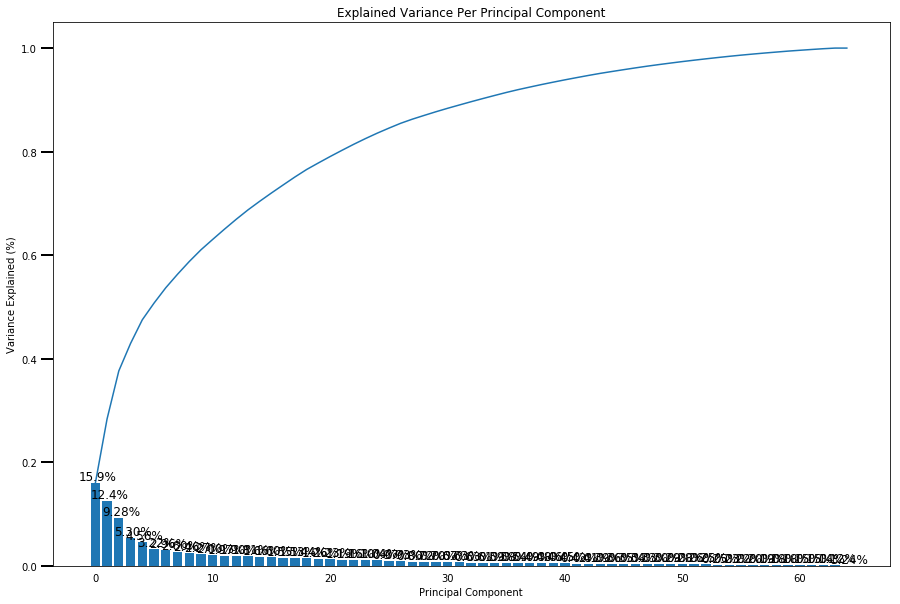

In [52]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.

azdias.shape


(891221, 65)

In [54]:
pca.explained_variance_ratio_[:].sum()

1.0

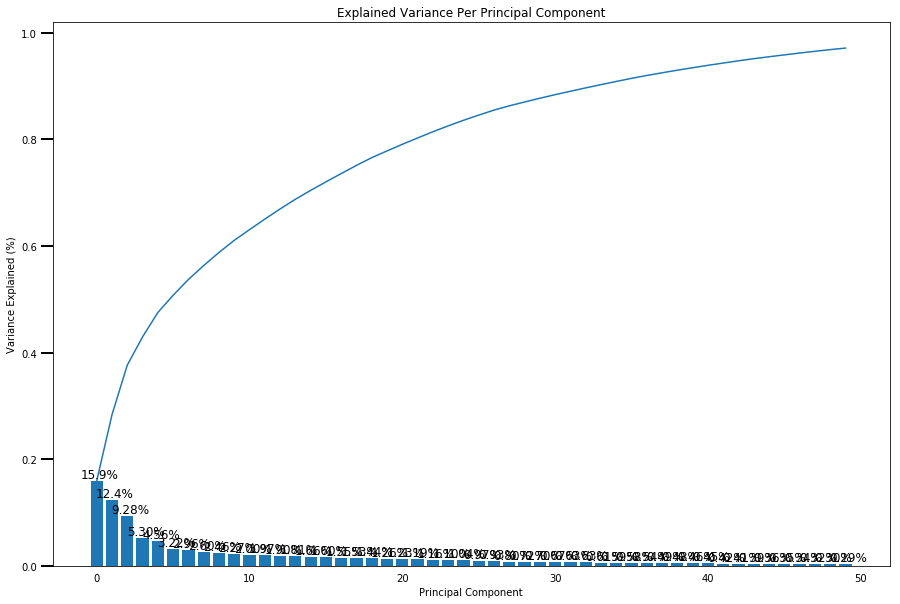

In [55]:
pca = PCA(n_components=50)
pca_df = pca.fit_transform(scaled_df)
scree_plot(pca)

In [56]:
pca.explained_variance_ratio_[:50].sum()

0.97105707029561239

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Answer:
I reduced the dimensionality to 50 and still we have very high explained_variance_ratio around 97.2% which is okey
we can go more depend on the accurecy of data.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weight(df, component):
    pca_df = pd.DataFrame(pca.components_, columns=list(df.columns))
    pca_component = pd.DataFrame(pca_df.iloc[component])
    print(pca_component.sort_values(component, ascending=False))
        




In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weight(azdias,0)

                              0
PLZ8_ANTG3             0.219363
wealth                 0.207272
EWDICHTE               0.196007
FINANZ_SPARER          0.182577
ORTSGR_KLS9            0.179028
PLZ8_ANTG4             0.170343
PLZ8_ANTG2             0.150050
SEMIO_REL              0.148713
generation             0.147466
ARBEIT                 0.147298
SEMIO_PFLICHT          0.145327
HH_EINKOMMEN_SCORE     0.142483
FINANZ_HAUSBAUER       0.141668
KBA05_ANTG4            0.130378
FINANZ_UNAUFFAELLIGER  0.124751
RELAT_AB               0.124315
SEMIO_RAT              0.119427
FINANZ_ANLEGER         0.119247
ANZ_HAUSHALTE_AKTIV    0.112869
KBA05_ANTG3            0.111546
SEMIO_MAT              0.099573
SEMIO_TRADV            0.099132
SEMIO_FAM              0.096709
REGIOTYP               0.077776
HEALTH_TYP             0.067303
SEMIO_KAEM             0.065674
SEMIO_KULT             0.061307
VERS_TYP               0.050063
SEMIO_DOM              0.049227
KKK                    0.047225
...     

In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weight(azdias,1)


                              1
ALTERSKATEGORIE_GROB   0.245721
FINANZ_VORSORGER       0.225186
SEMIO_ERL              0.213507
SEMIO_LUST             0.169506
RETOURTYP_BK_S         0.166544
FINANZ_HAUSBAUER       0.143326
PLZ8_ANTG4             0.139374
ORTSGR_KLS9            0.130247
PLZ8_ANTG3             0.125968
KBA05_ANTG4            0.105272
W_KEIT_KIND_HH         0.104968
EWDICHTE               0.102503
HH_EINKOMMEN_SCORE     0.099313
ANZ_HAUSHALTE_AKTIV    0.094874
RELAT_AB               0.091115
PLZ8_ANTG2             0.087900
wealth                 0.083001
SEMIO_KAEM             0.079720
ARBEIT                 0.078301
KBA05_ANTG3            0.078081
SEMIO_KRIT             0.070657
ANREDE_KZ              0.065431
WOHNDAUER_2008         0.043521
SEMIO_DOM              0.042697
ANZ_HH_TITEL           0.041203
FINANZ_MINIMALIST      0.040700
PLZ8_HHZ               0.031429
nation                 0.026274
VERS_TYP               0.020658
KBA05_ANTG2            0.014686
...     

In [60]:
map_weight(azdias,2)

                              2
SEMIO_VERT             0.346608
SEMIO_SOZ              0.297409
SEMIO_KULT             0.287624
SEMIO_FAM              0.225886
PLZ8_ANTG4             0.109152
FINANZ_MINIMALIST      0.089379
ORTSGR_KLS9            0.077372
SEMIO_MAT              0.075682
RETOURTYP_BK_S         0.070256
HH_EINKOMMEN_SCORE     0.063485
KBA05_ANTG4            0.063345
ANZ_HAUSHALTE_AKTIV    0.061867
SEMIO_REL              0.058366
movement               0.057290
GREEN_AVANTGARDE       0.057290
PLZ8_ANTG3             0.053510
KBA05_ANTG3            0.051981
RELAT_AB               0.047327
FINANZ_VORSORGER       0.039940
KBA05_ANTG2            0.036468
PLZ8_ANTG2             0.035355
PLZ8_HHZ               0.032203
life_stage             0.027811
ANZ_HH_TITEL           0.023330
ANZ_PERSONEN           0.021685
ALTERSKATEGORIE_GROB   0.018888
EWDICHTE               0.016906
ARBEIT                 0.016151
W_KEIT_KIND_HH         0.011462
ANZ_TITEL              0.010966
...     

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### Answer:
Acutally I don't have information naming of the featurs but we can notice the similarities of the name such as below:
#### Compenent#1

This compenent is mostly about the family house and how is the density of the people in the house. mostly they are welthy and in good finacial situation.

    
#### Compenent#2

Mostly estimated for age factor and financial be preped beside semsual minded and event orinted person.


#### Compenent#3

This compennet mostly regarding perosnality,dreamful, socially minded, and cultural minded

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [61]:
# Over a number of different cluster counts...

#recall lession: __cluster function__ 

from sklearn.cluster import KMeans

def get_kmeans_score(df, center):
    kmeans = KMeans(center)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    
    return score


--- Run time: 32.68 mins ---


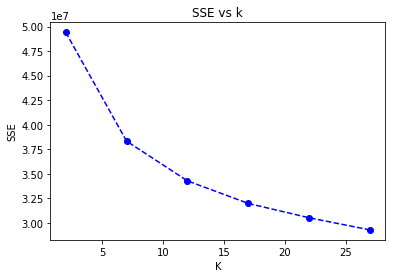

In [62]:
import time
start_time = time.time()
scores = []
centers = list(range(2, 30,5))

for c in centers:
    scores.append(get_kmeans_score(pca_df, c))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs k');
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(20)
new_knn = model.fit(pca_df)
k_pre = new_knn.predict(pca_df)
print(k_pre)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

[ 8  9  4 ...,  6 17 18]
--- Run time: 39.39 mins ---


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';',)

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned_customers = clean_data(customers)


In [66]:
to_drop = []
for i in cleaned_customers.columns:
    if i not in scaled_df.columns:
        to_drop.append(i)
print(to_drop)
for d in to_drop:
    cleaned_customers.drop(d, axis=1, inplace=True)



['GEBURTSJAHR', 'ALTER_HH']


In [67]:
print(len(cleaned_customers.columns))
print(len(scaled_df.columns))

65
65


In [68]:

imputed_df = pd.DataFrame(imputer.fit_transform(cleaned_customers), columns = cleaned_customers.columns, index = cleaned_customers.index)
scaled_customers = pd.DataFrame(scaler.fit_transform(imputed_df), columns = imputed_df.columns, index = imputed_df.index)
pca_customers = pca.fit_transform(scaled_customers)
kpre_customers = model.predict(pca_customers)
kpre_customers

array([ 0,  8, 15, ...,  9,  3, 14], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_clusters = pd.Series(k_pre)
popc = population_clusters.value_counts().sort_index()
popc = pd.Series(popc)
#popc

customer_clusters = pd.Series(kpre_customers)
custc = customer_clusters.value_counts().sort_index()
custc = pd.Series(custc)
#custc

In [70]:
pop_cust = pd.concat([popc, custc], axis=1).reset_index()
pop_cust.columns = ['cluster', 'population', 'customers']



# Sort by cluster (index)
pop_cust.sort_index(inplace=True)

# Calculate proprotions
pop_cust['cust_prop'] = pop_cust['customers'] / pop_cust['customers'].sum()
pop_cust['pop_prop'] = pop_cust['population'] / pop_cust['population'].sum()
pop_cust

,cluster,population,customers,cust_prop,pop_prop
0,0,41880,27042,0.141099,0.046992
1,1,48903,20791,0.108483,0.054872
2,2,66980,2154,0.011239,0.075155
3,3,53417,16271,0.084899,0.059937
4,4,54188,736,0.003840,0.060802
5,5,53852,1229,0.006413,0.060425
6,6,74761,23693,0.123625,0.083886
7,7,35333,8969,0.046798,0.039646
8,8,78007,11570,0.060370,0.087528
9,9,69872,7116,0.037130,0.078400


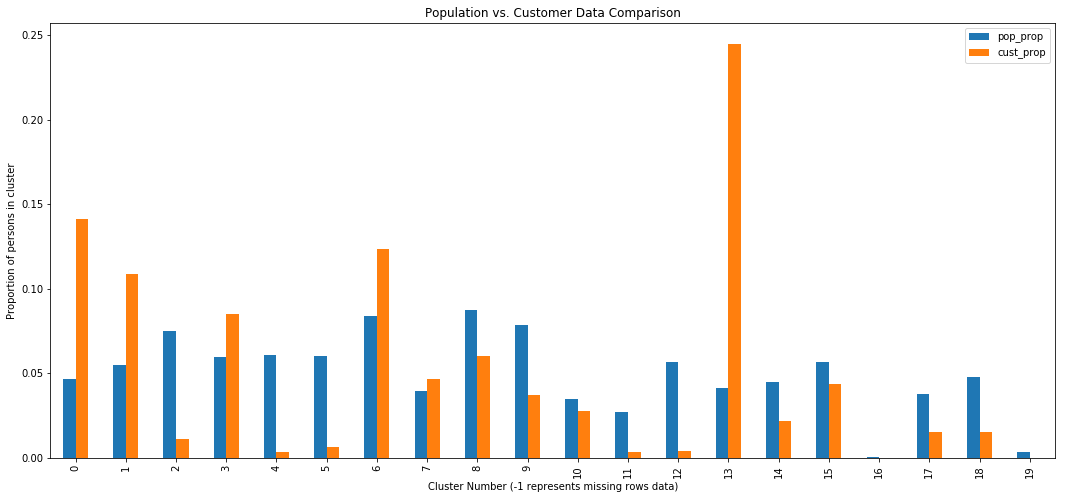

In [71]:
pop_cust.plot(x='cluster', y=['pop_prop', 'cust_prop'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customer Data Comparison')
plt.xlabel('Cluster Number (-1 represents missing rows data)')
plt.ylabel('Proportion of persons in cluster')
plt.show()

### I will investigate cluster [2,4,7,8,14,16]

In [72]:

def get_counts(df):
    for i in df.columns:
        print(df[i].value_counts())

In [73]:
kpre_customers

array([ 0,  8, 15, ...,  9,  3, 14], dtype=int32)

In [74]:
# cluster 2
df = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==2)])).round()
dfc = pd.DataFrame(data=df, columns=azdias.columns, index=np.array(range(0, len(df))))
get_counts(dfc)

3.0    916
4.0    729
2.0    325
1.0    182
0.0      2
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    2154
Name: ANREDE_KZ, dtype: int64
4.0    974
5.0    638
3.0    273
2.0    214
1.0     55
Name: FINANZ_MINIMALIST, dtype: int64
1.0    930
2.0    578
4.0    415
3.0    205
5.0     26
Name: FINANZ_SPARER, dtype: int64
5.0    1016
4.0     534
2.0     344
3.0     238
1.0      20
6.0       2
Name: FINANZ_VORSORGER, dtype: int64
2.0    963
3.0    527
4.0    354
5.0    203
1.0    104
6.0      3
Name: FINANZ_ANLEGER, dtype: int64
3.0    1006
2.0     459
4.0     315
5.0     268
1.0      87
6.0      17
0.0       2
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
3.0    902
1.0    593
2.0    355
4.0    232
5.0     57
0.0     15
Name: FINANZ_HAUSBAUER, dtype: int64
-0.0    1617
 1.0     537
Name: GREEN_AVANTGARDE, dtype: int64
2.0    1368
3.0     479
1.0     307
Name: HEALTH_TYP, dtype: int64
5.0    693
3.0    667
2.0    510
4.0    176
1.0    108
Name: RETOURTYP_BK_S, dtype: int64
2.0    1046
4.0     7

In [75]:
# cluster 4
df = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==4)])).round()
dfc = pd.DataFrame(data=df, columns=azdias.columns, index=np.array(range(0, len(df))))
get_counts(dfc)

1.0    310
3.0    202
2.0    186
4.0     24
0.0     13
5.0      1
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    683
1.0     53
Name: ANREDE_KZ, dtype: int64
3.0    245
1.0    179
2.0    168
4.0    117
5.0     27
Name: FINANZ_MINIMALIST, dtype: int64
4.0    339
1.0    144
3.0     99
2.0     83
5.0     71
Name: FINANZ_SPARER, dtype: int64
2.0    315
5.0    146
3.0    120
4.0    114
1.0     40
6.0      1
Name: FINANZ_VORSORGER, dtype: int64
5.0    270
4.0    174
2.0    140
3.0    122
6.0     23
1.0      7
Name: FINANZ_ANLEGER, dtype: int64
4.0    266
3.0    137
5.0    130
2.0    107
1.0     86
6.0      6
0.0      4
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
4.0    189
3.0    188
5.0    145
2.0    119
1.0     86
0.0      5
6.0      4
Name: FINANZ_HAUSBAUER, dtype: int64
-0.0    734
 1.0      2
Name: GREEN_AVANTGARDE, dtype: int64
3.0    334
2.0    306
1.0     96
Name: HEALTH_TYP, dtype: int64
2.0    184
3.0    165
4.0    153
1.0    120
5.0    114
Name: RETOURTYP_BK_S, dtype: int64
2.0    

In [76]:
# cluster 7
df = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==7)])).round()
dfc = pd.DataFrame(data=df, columns=azdias.columns, index=np.array(range(0, len(df))))
get_counts(dfc)

4.0    6369
3.0    2208
2.0     182
1.0     150
5.0      56
0.0       4
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    6051
1.0    2918
Name: ANREDE_KZ, dtype: int64
3.0    4983
2.0    2958
4.0     701
1.0     250
5.0      60
0.0      17
Name: FINANZ_MINIMALIST, dtype: int64
1.0    7047
2.0    1065
3.0     572
4.0     262
5.0      22
0.0       1
Name: FINANZ_SPARER, dtype: int64
5.0    6324
4.0    1806
3.0     550
2.0     218
1.0      61
6.0      10
Name: FINANZ_VORSORGER, dtype: int64
1.0    5283
2.0    2487
3.0     724
4.0     295
0.0     113
5.0      67
Name: FINANZ_ANLEGER, dtype: int64
 1.0    4679
 2.0    3090
 0.0     476
 3.0     469
 4.0     197
 5.0      44
-1.0      14
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
5.0    6170
4.0    1916
3.0     546
2.0     177
6.0     146
1.0      14
Name: FINANZ_HAUSBAUER, dtype: int64
0.0    8022
1.0     947
Name: GREEN_AVANTGARDE, dtype: int64
2.0    5744
1.0    1941
3.0    1284
Name: HEALTH_TYP, dtype: int64
5.0    5495
3.0    2057
4.0    

In [77]:
# cluster 8
df = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==8)])).round()
dfc = pd.DataFrame(data=df, columns=azdias.columns, index=np.array(range(0, len(df))))
get_counts(dfc)

4.0    10891
5.0      390
3.0      288
2.0        1
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    10562
2.0     1008
Name: ANREDE_KZ, dtype: int64
5.0    10348
4.0     1125
3.0       60
6.0       37
Name: FINANZ_MINIMALIST, dtype: int64
1.0    11511
2.0       57
0.0        2
Name: FINANZ_SPARER, dtype: int64
5.0    11287
4.0      278
6.0        5
Name: FINANZ_VORSORGER, dtype: int64
1.0    8760
2.0    2735
0.0      40
3.0      35
Name: FINANZ_ANLEGER, dtype: int64
2.0    6987
1.0    4228
3.0     336
0.0      19
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    8085
3.0    2061
4.0     795
1.0     456
5.0     173
Name: FINANZ_HAUSBAUER, dtype: int64
-0.0    5841
 1.0    5729
Name: GREEN_AVANTGARDE, dtype: int64
1.0    6226
2.0    5214
3.0     130
Name: HEALTH_TYP, dtype: int64
5.0    6509
3.0    3644
4.0    1114
2.0     217
1.0      86
Name: RETOURTYP_BK_S, dtype: int64
6.0    4738
3.0    3913
4.0    2279
2.0     259
5.0     256
1.0     125
Name: SEMIO_SOZ, dtype: int64
4.0    3840
6.0

In [78]:
# cluster 14
df = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==14)])).round()
dfc = pd.DataFrame(data=df, columns=azdias.columns, index=np.array(range(0, len(df))))
get_counts(dfc)

3.0    2046
2.0    1281
4.0     429
1.0     418
5.0       3
0.0       1
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    4008
2.0     170
Name: ANREDE_KZ, dtype: int64
5.0    2739
4.0    1014
3.0     385
2.0      23
6.0      15
1.0       2
Name: FINANZ_MINIMALIST, dtype: int64
2.0    2091
4.0    1023
1.0     587
3.0     450
5.0      27
Name: FINANZ_SPARER, dtype: int64
4.0    2002
2.0     981
3.0     589
5.0     567
1.0      38
6.0       1
Name: FINANZ_VORSORGER, dtype: int64
2.0    1518
3.0    1255
4.0     922
1.0     299
5.0     180
6.0       4
Name: FINANZ_ANLEGER, dtype: int64
3.0    1725
2.0    1016
4.0     877
5.0     376
1.0     156
6.0      23
0.0       5
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
1.0    3179
2.0     689
0.0     185
3.0     105
4.0      19
5.0       1
Name: FINANZ_HAUSBAUER, dtype: int64
-0.0    2752
 1.0    1426
Name: GREEN_AVANTGARDE, dtype: int64
3.0    1940
1.0    1262
2.0     976
Name: HEALTH_TYP, dtype: int64
3.0    1541
4.0    1017
5.0     905
1.0     388


In [79]:
# cluster 16
df = scaler.inverse_transform(pca.inverse_transform(pca_customers[np.where(kpre_customers==16)])).round()
dfc = pd.DataFrame(data=df, columns=azdias.columns, index=np.array(range(0, len(df))))
get_counts(dfc)

4.0    15
3.0     6
1.0     3
Name: ALTERSKATEGORIE_GROB, dtype: int64
2.0    15
1.0     9
Name: ANREDE_KZ, dtype: int64
2.0    9
3.0    9
4.0    3
5.0    2
1.0    1
Name: FINANZ_MINIMALIST, dtype: int64
1.0    20
2.0     2
4.0     2
Name: FINANZ_SPARER, dtype: int64
5.0    18
4.0     4
2.0     2
Name: FINANZ_VORSORGER, dtype: int64
1.0    16
2.0     6
3.0     1
4.0     1
Name: FINANZ_ANLEGER, dtype: int64
1.0    15
3.0     4
2.0     2
4.0     2
0.0     1
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
5.0    14
4.0     5
3.0     2
6.0     2
2.0     1
Name: FINANZ_HAUSBAUER, dtype: int64
0.0    13
1.0    11
Name: GREEN_AVANTGARDE, dtype: int64
1.0    11
2.0    10
3.0     3
Name: HEALTH_TYP, dtype: int64
5.0    14
3.0     7
1.0     1
2.0     1
4.0     1
Name: RETOURTYP_BK_S, dtype: int64
5.0    8
1.0    7
3.0    4
6.0    4
7.0    1
Name: SEMIO_SOZ, dtype: int64
2.0    11
3.0     6
5.0     2
4.0     2
6.0     2
7.0     1
Name: SEMIO_FAM, dtype: int64
1.0    10
4.0     5
2.0     4
5.0     2
3.0

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Answer:

Let summry all ourput in the table below:


|Header|Cluster:1|Cluster:4|Cluster:7|Cluster:8|Cluster:14|Cluster:16|
|------|------|------|------|------|------|------|
|Genration |1     |2     |1     |1     |1     |1     |
|Movement  |1     |2     |2     |2     |2     |1     |
|Nation    |3     |3     |3     |3     |3     |3     |
|Wealth    |4     |2     |2     |1     |4     |2     |
|Lif Style |4     |4     |4     |4     |4     |4     |

As you can see the above table is ovservation of some cluster that looks high and after investigate we see that life style is always for which mean Older Families&Mature Couples, and older generation as well,most of data show that nation is mixed and it is not big issue. Welthy people might be good factor specaly for top cluster which is 4,8,14.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.